# Home Credit Default Risk

By Atwine Mugume Twinamatsiko

I have studied some good examples and I hope to make my predictions better. In this notebook I am going to apply some of the techniques I have learnt over the past weeks of reading.

I will clearly note and demontrate what i am doing for easy following:

### Importing the necesary Libraries

In [1]:
import matplotlib.pyplot as plt #this is for visualization
import numpy as np #this is for matrix calculation and maths
import pandas as pd #this is for data manipulation
import seaborn as sns #this is also to help in visualization 
import featuretools as ft #used for auto feature generation where we have many datasets
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split #to help in spliting the data
from sklearn.metrics import mean_squared_error #this is to test the accuracy of the model
from sklearn import cross_validation #to help in feature selection

# I need to install xgboost as my ML method and other parameters I may have forgotten
# I am going to need feature tools since I have many dataframes so that I can create more features

# Suppress warnings 
import warnings 
warnings.filterwarnings('ignore')


/Volumes/BackUP/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Injest the data into data frames


In [2]:
df_test = pd.read_csv('./application_test.csv')
df_train = pd.read_csv('./application_train.csv')
df_bureau = pd.read_csv('./bureau_balance.csv')
credit_card_bal = pd.read_csv('./credit_card_balance.csv')
instalments = pd.read_csv('./installments_payments.csv')
POS_cash = pd.read_csv('./POS_CASH_balance.csv')

# Initial Data Exploration
### Look into the training data set to get some exploration going on;
#### What are we looking for?
> Data anomalies

> Missing data

> Multicollinearity

> Standardizing the data after which we will do feature engineering

In [25]:
#how big are our data sets?
df_bureau.shape,df_test.shape,df_train.shape,credit_card_bal.shape,instalments.shape,POS_cash.shape

((27299925, 3),
 (48744, 242),
 (307511, 244),
 (3840312, 23),
 (13605401, 8),
 (10001358, 8))

In [26]:
#I want to look at the variables in the train dataset because it is the most important dataset
df_train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,252137.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,16036.995067,-2384.169325,-4986.120328,...,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570,0.080729
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,2338.360162,3522.886321,...,0.170835,0.086085,0.075840,0.072501,0.410654,0.407858,0.130892,0.499660,0.086679,0.272419
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,7489.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,12413.000000,-3175.000000,-7479.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,15750.000000,-1648.000000,-4504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,367142.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,19682.000000,-767.000000,-2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,25229.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
#how many empty values do we have
df_train.isnull().any().sum()

62

### Explore the Target Column

In [28]:
df_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

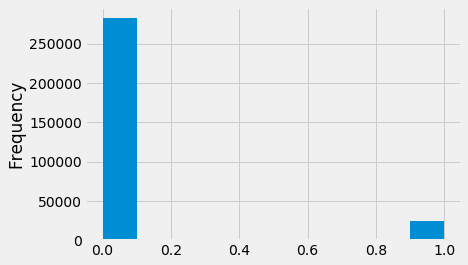

In [29]:
#let us look at the distribution of the target
df_train['TARGET'].plot.hist()
#so we see here that there are more defaults than those that have paid their loans back

In [30]:
#check for missing values:
def miss_val(df):
    #the number of missing values
    val_miss = df.isnull().sum()
    
    #percentage of the missing values
    perc_miss = 100* df.isnull().sum()/len(df)
    
    #put the two together to form a table
    miss_table = pd.concat([val_miss,perc_miss], axis= 1)
    
    #rename the columns
    fin_mis_table = miss_table.rename(columns = {0:'Missing Values', 1: 'Percentage'})
    
    #sort the values in descending order
    final_table = fin_mis_table[fin_mis_table.iloc[:,1]!=0].sort_values('Percentage', ascending = False ).round(2)
    
    return final_table

In [31]:
miss_val(df_train).head(20)

,Missing Values,Percentage
COMMONAREA_MODE,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MEDI,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
FLOORSMIN_MODE,208642,67.85


In [32]:
#how many data types do we have
df_train.dtypes.value_counts()

uint8      137
float64     66
int64       40
bool         1
dtype: int64

In [33]:
#we have 16 data types that are non numeric
#lets see them
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [34]:
#since we have many values that are categorical we need to encode them because they are not easily handled

#create the encoder object
# labE = LabelEncoder()
# le_count = 0 #to keep track of the encoded

# for col in df_train:
#     if df_train[col].dtype == 'object':
#         #we want to encode the labels with fewer labels
#         if len(list(df_train[col].unique())) <= 2:
#             #train on the data
#             labE.fit(df_train[col])
#             #transform all the dataframes.
#             df_test[col] = labE.transform(df_test[col])
#             df_train[col]= labE.transform(df_train[col])
            
#             le_count += 1
            
# print('Were transformed', le_count)


In [35]:
#one hot encoding
df_test = pd.get_dummies(df_test)
df_train = pd.get_dummies(df_train)

print('Shape', df_test.shape)
print('Shape', df_train.shape)

Shape (48744, 242)
Shape (307511, 244)


In [36]:
#one hot encoding creates many more columns and so the dataframes are not aligned 
#let's align the datasets

#first we take out the target column
target_label = df_train['TARGET']

df_train,df_test = df_train.align(df_test,axis=1,join='inner')

#replace the target column
df_train['TARGET'] = target_label

print('Test Shape',df_test.shape)
print('Train Train', df_train.shape)

Test Shape (48744, 242)
Train Train (307511, 243)


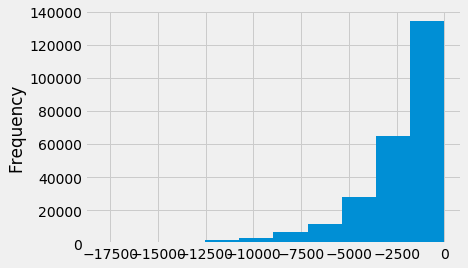

In [37]:
#there is an anomaly in the number of days worked, the days are so many so we will replace them
#CREATE A FLAG COLUMN FOR THE ANOMALY DAYS
df_train['DAYS_EMPLOYED_ANOMALY'] = df_train['DAYS_EMPLOYED']== 365243

#replace the days which are abnormal
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_train['DAYS_EMPLOYED'].plot.hist()

## The next issue we need to look at is correlations

Very high correlation means we maybe inputing data of the same type into the model hence overfitting. So this kind of data should be removed from the equation such that, the model will have some real data to work with

In [38]:
#from numpy we have a correlation function, using pearson's correlation
correlation = df_train.corr()['TARGET'].sort_values()

print('Least correlated', correlation.tail(10))
print('Most correlated', correlation.head(10))

Least correlated REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
TARGET                         1.000000
DAYS_EMPLOYED_ANOMALY               NaN
Name: TARGET, dtype: float64
Most correlated EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
DAYS_BIRTH                             -0.078239
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: float64


In [39]:
#there is a high correlation between target and the days birth
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07823930830982706

(array([13679., 33111., 38424., 41746., 40356., 34339., 33544., 32650.,
        27685., 11977.]),
 array([20.51780822, 25.37808219, 30.23835616, 35.09863014, 39.95890411,
        44.81917808, 49.67945205, 54.53972603, 59.4       , 64.26027397,
        69.12054795]),
 <a list of 10 Patch objects>)

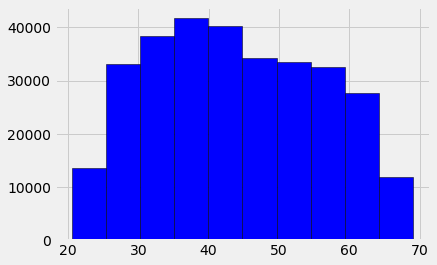

In [40]:
# let's plot the fig and see how it looks like
plt.style.use('fivethirtyeight')

plt.hist(df_train['DAYS_BIRTH']/365, bins=10, color= 'blue', edgecolor = 'k')

# Feature Engineering:
For feature engineering,  I want to use feature tools to create new features 
- There are some ways to create features one of which is polynomial features
- But first we will use random forest to look at the most important features in the dataframe

### Polinomial Features:

These are features with powers, for example if we have x, the x^2
- we use the variables with the highest negative correlation to create the features, the reason we do this is because, the lesser the correlation, the better the variable is to help separate the differences and there by helping the model.

In [41]:
#first we create a list of the variables
poly_train = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_test = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

#to handle missing values we use the imputer to fill them in based on the mean
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

#we take the target column out because we don't want to add anything
poly_target = poly_train['TARGET']

#lets drop it from the poly_train df
poly_train = poly_train.drop(columns = ['TARGET'])

#now lets impute the values into the dataframes
poly_train = imputer.fit_transform(poly_train)
poly_test = imputer.transform(poly_test)

#lets now bring in the polynomial feature creator
#we will create the features to the 4 degree to prevent over fitting

from sklearn.preprocessing import PolynomialFeatures

#we create the polynomial feature object
poly_creator = PolynomialFeatures(degree=4)


In [42]:
#we fit the poly features/ train the features on the training data
poly_creator.fit(poly_train)


#now we need to  in put the data frames created
poly_train_ft = poly_creator.transform(poly_train)
poly_test_ft = poly_creator.transform(poly_test)

print('Poly Features Shape:', poly_train_ft.shape)
print('Poly Features Shape:', poly_test_ft.shape)

Poly Features Shape: (307511, 70)
Poly Features Shape: (48744, 70)


The number of features created have been increased and it could cause over fitting, in order to see the features created we use the code below.

In [43]:
poly_creator.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:20]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2']

In [45]:
poly_df = pd.DataFrame(poly_train_ft)

In [46]:
#return the target column into the data created
poly_df['TARGET']= poly_target

#lets now look at the features correlation
poly_corr = poly_df.corr()['TARGET'].sort_values()

#display the top 10 and bottom 10
print(poly_corr.head(10))
print('-'*20)
print(poly_corr.tail(10))

10   -0.193939
20   -0.189605
29   -0.181283
26   -0.176428
46   -0.174534
49   -0.174173
28   -0.172282
48   -0.170938
59   -0.168159
6    -0.166625
Name: TARGET, dtype: float64
--------------------
54       -0.086895
38       -0.086309
15       -0.083005
4        -0.078239
14       -0.076672
35       -0.076126
34       -0.074273
69       -0.071465
TARGET    1.000000
0              NaN
Name: TARGET, dtype: float64


Right now we need to transform these df into the right data frames so we can test them

In [47]:
#we want a data frame from the info above
poly_df_ft = pd.DataFrame(poly_test_ft, columns = poly_creator.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [48]:
'SK_ID_CURR' in df_train.columns

True

In [55]:
type(poly_train)

numpy.ndarray

In [60]:

#lets merge the training data frame with the features
poly_df_ft['SK_ID_CURR'] = df_train['SK_ID_CURR']
train_poly = df_train.merge(poly_df_ft, on = 'SK_ID_CURR', how = 'left')

#lets join the testing data witht he poly features
poly_df_ft['SK_ID_CURR']= df_test['SK_ID_CURR']
test_poly = df_test.merge(poly_df_ft, on = 'SK_ID_CURR', how = 'left')

train_poly,test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

print('Shape of the training data:',train_poly.shape)
print('Shape of the testing data:',test_poly.shape)

Shape of the training data: (307511, 312)
Shape of the testing data: (48744, 312)


## Random Forest Classifier Using the polynomial Features:



In [61]:
#lets get the polynomial feature names
poly_feature_names = list(train_poly.columns)

#impute the polynomial features
train_poly = imputer.fit_transform(train_poly)
test_poly = imputer.transform(test_poly)

#scale the features so they can be in the range of 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))

train_poly = scaler.fit_transform(train_poly)
test_poly = scaler.transform(test_poly)

from sklearn.ensemble import RandomForestClassifier

poly_classiffier = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)



In [62]:
poly_classiffier.fit(train_poly,target_label)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [64]:
predictions = poly_classiffier.predict_proba(test_poly)[:,1]

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


In [65]:
submit = df_test[['SK_ID_CURR']]
submit['TARGET']= predictions

In [66]:
submit.shape

(48744, 2)

In [67]:
submit.to_csv('Random_Forest_HandIn.csv',index= False)